In [1]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Add, Concatenate
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

import tensorflow as tf
import numpy as np
from PIL import Image
import os 
import time
import matplotlib.pyplot as plt
import cv2

In [2]:
IMG_SIZE = 64
IMG_CHANNELS = 3
DIR = 'E:/Projects/Neural Net/BE Project/Image Colorization/Dataset/final_upload/'

In [3]:
x_train = np.load('train_data.npy')
y_train = np.load('train_labels.npy')

In [4]:
print(x_train.shape, y_train.shape)

(4776, 64, 64, 1) (4776, 64, 64, 3)


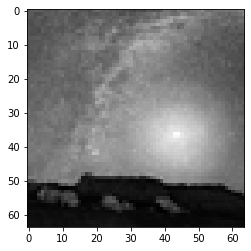

In [5]:
plt.imshow(x_train[0], cmap = 'gray')

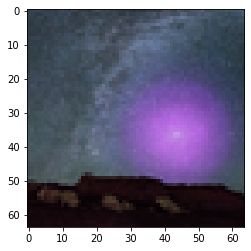

In [7]:
plt.imshow(y_train[0])

In [8]:
x_train = x_train/255
y_train = y_train/255

## Building blocks of our residual down_sampling

In [9]:
def conv_block(X, filters, stage=None, unit=None, weights = None, downsample = True):
    
    strides = 1
    if(downsample):
        strides = 2
    
    number = 1
    
    X = Activation('relu', name=f'stage{stage}_unit{unit}_relu{number}')(X)
    
    
    X_shortcut = X
    
    
    X = ZeroPadding2D(padding=((1,1),(1,1)), name=f'stage{stage}_unit{unit}_zeropad{number}')(X)
    
    X = Conv2D(filters = filters, kernel_size = (3,3), strides = (strides, strides),
               name=f'stage{stage}_unit{unit}_conv{number}', trainable = False,
               weights = weights[f'stage{stage}_unit{unit}_conv{number}'], use_bias = False)(X)
    
    number = 2
    
    X = BatchNormalization(name=f'stage{stage}_unit{unit}_bn{number}',
                           trainable = False,
                           weights = weights[f'stage{stage}_unit{unit}_bn{number}'])(X)
    
    X = Activation('relu', name=f'stage{stage}_unit{unit}_relu{number}')(X)
    
    X = ZeroPadding2D(padding=((1,1),(1,1)), name=f'stage{stage}_unit{unit}_zeropad{number}')(X)
    
    X = Conv2D(filters = filters, kernel_size = (3,3), strides = (1,1),
               name=f'stage{stage}_unit{unit}_conv{number}', trainable = False,
               weights = weights[f'stage{stage}_unit{unit}_conv{number}'], use_bias = False)(X)
    
    X_shortcut = Conv2D(filters = filters, kernel_size = (1,1), strides = (strides, strides),
                        name=f'stage{stage}_unit{unit}_sc', trainable = False,
                        weights = weights[f'stage{stage}_unit{unit}_sc'], use_bias = False)(X_shortcut)
    
    X = Add(name = f'stage{stage}_unit{unit}_add')([X,X_shortcut])
    
    return X



def simple_block(X, filters, stage=None, unit=None, weights = None):
    number = 1
    strides = 1
    
    X = BatchNormalization(name=f'stage{stage}_unit{unit}_bn{number}',
                           trainable = False,
                           weights = weights[f'stage{stage}_unit{unit}_bn{number}'])(X)
    
    X = Activation('relu',name=f'stage{stage}_unit{unit}_relu{number}')(X)
    
    
    X = ZeroPadding2D(padding=((1,1),(1,1)), name=f'stage{stage}_unit{unit}_zeropad{number}')(X)
    
    X = Conv2D(filters = filters, kernel_size = (3,3), strides = (strides, strides),
               name=f'stage{stage}_unit{unit}_conv{number}', trainable = False,
               weights = weights[f'stage{stage}_unit{unit}_conv{number}'], use_bias = False)(X)
    
    number = 2
    
    X = BatchNormalization(name=f'stage{stage}_unit{unit}_bn{number}',
                           trainable = False,
                           weights = weights[f'stage{stage}_unit{unit}_bn{number}'])(X)
    
    X = Activation('relu',name=f'stage{stage}_unit{unit}_relu{number}')(X)
    
    X = ZeroPadding2D(padding=((1,1),(1,1)), name=f'stage{stage}_unit{unit}_zeropad{number}')(X)
    
    X = Conv2D(filters = filters, kernel_size = (3,3), strides = (1,1),
               name=f'stage{stage}_unit{unit}_conv{number}', trainable = False,
               weights = weights[f'stage{stage}_unit{unit}_conv{number}'], use_bias = False)(X)
    
    return X

In [10]:
def downsample(X,filters, stage = None, weights = None, downsample = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    X_in = BatchNormalization(name=f'stage{stage}_unit1_bn1',
                               trainable = False,
                               weights = weights[f'stage{stage}_unit1_bn1'])(X)
    X_out_conv = conv_block(X_in, filters, stage=stage, unit=1, weights = weights, downsample = downsample)
    
    X_out_simple = simple_block(X_out_conv, filters=filters, stage=stage, unit=2, weights = weights)
    
    X_out = Add(name = f'stage{stage}_add_skipconn')([X_out_conv,X_out_simple])

    return [X_in, X_out]

def upsample(X, filters,size, stage = None, downsample = False):
    initializer = tf.random_normal_initializer(0., 0.02)

    X_in = Conv2DTranspose(filters, size, strides=2,
                            padding='same',
                            name = f'stage{stage}_convtranspose',
                            kernel_initializer=initializer,
                            use_bias=False)(X)

    X_in = BatchNormalization(name = f'stage{stage}_bn')(X_in)
    X_out = LeakyReLU(name = f'stage{stage}_leakyRelu')(X_in)

    return X_out

In [11]:
# for keras
from classification_models.keras import Classifiers

# for tensorflow.keras
# from classification_models.tfkeras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')
resnet18 = ResNet18((256, 256, 3), weights='imagenet')

weight_dict = {}

for layer in resnet18.layers:
    if(len(layer.weights)==0):
        continue
    weights = []
    for w in layer.weights:
        weights.append(w.numpy())
    weight_dict[layer.name] = weights

Using TensorFlow backend.


In [12]:
def Generator(weights):
    inputs = Input(shape=(64, 64, 1))
    initializer = tf.random_normal_initializer(0., 0.02)
    
    head = Conv2DTranspose(filters=3, kernel_size=4, 
                           strides=2, padding='same',
                           kernel_initializer=initializer,
                           activation='tanh')(inputs) # (bs, 128, 128, 3)
    
    first = Conv2D(filters=64, kernel_size=4,
                    strides=2, padding='same',
                    kernel_initializer=initializer,
                    activation='relu')(head) # (bs, 64, 64, 64)
    
    down_stack_blk1 = downsample(first, filters = 64, stage = 1, weights = weights, downsample = False)  # (bs, 128, 128, 64)
    down_stack_blk2 = downsample(down_stack_blk1[1],filters = 128, stage = 2, weights = weights, downsample = True)  # (bs, 64, 64, 128)
    down_stack_blk3 = downsample(down_stack_blk2[1],filters = 256, stage = 3, weights = weights, downsample = True)  # (bs, 32, 32, 256)
    down_stack_blk4 = downsample(down_stack_blk3[1],filters = 512, stage = 4, weights = weights, downsample = True)  # (bs, 16, 16, 512)
    
    #Adding first of the final 3 layer
    pre_final_down1 = BatchNormalization(name = 'pre_final1_downsample_bn1')(down_stack_blk4[1])
    pre_final_down1 = LeakyReLU(name = 'pre_final1_downsample_leakyReLU1')(pre_final_down1)
    
    down_stack_blk5 = Conv2D(filters = 512, kernel_size = 4,
                             strides = 2, padding = 'same',
                            name = 'pre_final1_downsample_conv1')(pre_final_down1)
    
    #Adding second-last layer
    pre_final_down2 = BatchNormalization(name = 'pre_final2_downsample_bn1')(down_stack_blk5)
    pre_final_down2 = LeakyReLU(name = 'pre_final2_downsample_leakyReLU1')(pre_final_down2)
    
    down_stack_blk6 = Conv2D(filters = 512, kernel_size = 4,
                             strides = 2, padding = 'same',
                            name = 'pre_final2_downsample_conv1')(pre_final_down2)
    
    #Adding last layer
    final_down = BatchNormalization(name = 'final_downsample_bn1')(down_stack_blk6)
    final_down = LeakyReLU(name = 'final_downsample_leakyReLU1')(final_down)
    
    down_stack_blk7 = Conv2D(filters = 512, kernel_size = 4,
                             strides = 2, padding = 'same',
                            name = 'final_downsample_conv1')(final_down)
    
    
    

    down_stack = [
        down_stack_blk1[1],
        down_stack_blk2[1],
        down_stack_blk3[1],
        down_stack_blk4[1],
        down_stack_blk5,
        down_stack_blk6,
        down_stack_blk7
    ]
    
    up_stack_blk1 = upsample(down_stack_blk7, 512, 4, stage = 1)
    up = Concatenate()([up_stack_blk1, down_stack_blk6])
    
    up_stack_blk2 = upsample(up, 512, 4, stage = 2)
    up = Concatenate()([up_stack_blk2, down_stack_blk5])
    
    up_stack_blk3 = upsample(up, 512, 4, stage = 3)
    up = Concatenate()([up_stack_blk3, down_stack_blk4[1]])
    
    up_stack_blk4 = upsample(up, 256, 4, stage = 4)
    up = Concatenate()([up_stack_blk4, down_stack_blk3[1]])
    
    up_stack_blk5 = upsample(up, 128, 4, stage = 5)
    up = Concatenate()([up_stack_blk5, down_stack_blk2[1]])
    
    last = Conv2DTranspose(filters = 3, kernel_size = 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             activation='tanh')(up)  # (bs, 64, 64, 3)
    
    
    up_stack = [
        up_stack_blk1,
        up_stack_blk2,
        up_stack_blk3,
        up_stack_blk4,
        up_stack_blk5,
    ]
  
              
    model = Model(inputs = inputs, outputs = last)
    
    return model

In [13]:
model = Generator(weight_dict)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 128, 128, 3)  51          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        conv2d_transpose[0][0]           
__________________________________________________________________________________________________
stage1_unit1_bn1 (BatchNormaliz (None, 64, 64, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
opt = Adam(lr=1.5e-4)
model.compile(loss='mae',
              optimizer=opt, 
              metrics=['mae', 'accuracy'])

In [17]:
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, CSVLogger


class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

early_stopping = EarlyStopping(
    monitor='loss', patience=8, verbose=1, mode='auto')

history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(
    filepath='/content/drive/My Drive/BE_project/output/colorised/generator.hdf5', verbose=2, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=4,)

csv_logger = CSVLogger('/content/drive/My Drive/BE_project/output/colorised/generator_independent.csv')

In [18]:
hist = model.fit(x_train, y_train, batch_size = 32, epochs = 50)

Train on 4776 samples
Epoch 1/50
2560/4776 [===============>..............] - ETA: 31s - loss: 0.4902 - mae: 0.4902 - accuracy: 0.3865

KeyboardInterrupt: 